# trying to create a better grid builging algorithm

In [1]:
# load stuff
import json
import random
import numpy as np
from string import digits, ascii_lowercase
import pathlib
import logging
import copy

In [2]:
def get_difficulty_threshold(lang: str, difficulty: int):
    return get_difficulty_threshold.thresholds[lang][difficulty]


get_difficulty_threshold.thresholds = {
    'de': {
        0: 12,
        1: 6,
        2: 0
    },
    'en': {
        0: 200,
        1: 100,
        2: 10
    }
}


def get_database(lang: str = "en") -> dict:
    if lang not in get_database._dbs:
        try:
            file = __file__
        except:
            file = "./.tmp"
        current_folder = pathlib.Path(file).parents[0]
        db_file = str(current_folder / f"{lang}.json")

        logging.info("loading database: %s", lang)

        with open(db_file, "r") as f:
            db = json.load(f)
            get_database._dbs[lang] = db

        logging.info("database loaded")

    return get_database._dbs[lang]


get_database._dbs = {}

def build_inverted_index(db):

    inverted_db = {}

    inverted_db['#'] = {}
    number_db = inverted_db['#']

    for letter in ascii_lowercase:
        inverted_db[letter] = {}

    for key, item in db.items():
        try:
            word = item['word']
            norm_word = normalize_word(word)

            n = len(norm_word)

            if norm_word.isalnum():

                for i, letter in enumerate(norm_word):
                    letter_db = inverted_db[letter]
                    if i not in letter_db:
                        letter_db[i] = {}
                    letter_db_i = letter_db[i]
                    if n not in letter_db_i:
                        letter_db_i[n] = []
                    if n not in number_db:
                        number_db[n] = []
                    
                    letter_db_i[n].append(key)
                    number_db[n].append(key)
        except:
            pass
            #print("error processing " + word)
    
    return inverted_db

def get_inverted_database(lang: str) -> dict:
    if lang not in get_inverted_database._dbs:
        get_inverted_database._dbs[lang] = build_inverted_index(get_database(lang))
    return get_inverted_database._dbs[lang]

get_inverted_database._dbs = {}
        

remove_digits = str.maketrans('', '', digits)

def normalize_word(word: str):
    word = word.translate(remove_digits)
    return word.lower()

def find_suitable_words(constraints: list, db: dict, inverted_db: dict):
    sets = []

    n = len(constraints)
    for i,letter in enumerate(constraints):
        if letter == ' ':
            continue
        
        letter_db = inverted_db[letter]
        if i in letter_db:
            i_list = letter_db[i]
            
            if not n in i_list:
                return set()
            
            sets.append(set(i_list[n]))
        
        else:
            return set()
    
    # at least one constraint must be set
    if len(sets) == 0:
        
        # set first letter random and try again
        if n in inverted_db['#']:
            return inverted_db['#'][n]
        return set()
    
    return set.intersection(*sets)
    



In [3]:
find_suitable_words(list("  "), get_database("de"), get_inverted_database("de"))

['du',
 'du',
 'er',
 'er',
 'hi',
 'hi',
 'bp',
 'bp',
 'ol',
 'ol',
 'ei',
 'ei',
 'iq',
 'iq',
 'we',
 'we',
 'cd',
 'cd',
 'am',
 'am',
 'ha',
 'ha',
 'ei0',
 'ei0',
 'hi0',
 'hi0',
 'hi1',
 'hi1',
 'es',
 'es',
 'ai',
 'ai',
 'aa',
 'aa',
 'ag',
 'ag',
 'ag0',
 'ag0',
 'db',
 'db',
 'fc',
 'fc',
 'ab',
 'ab',
 'ab0',
 'ab0',
 'hp',
 'hp',
 'ms',
 'ms',
 'pa',
 'pa',
 'eh',
 'eh',
 'eh1',
 'eh1',
 'fs',
 'fs',
 'it',
 'it',
 'ki',
 'ki',
 'pc',
 'pc',
 'pc0',
 'pc0',
 'um',
 'um',
 'um0',
 'um0',
 'hr',
 'hr',
 'in',
 'in',
 'im',
 'im',
 'ir',
 'ir',
 'hf',
 'hf',
 'cu',
 'cu',
 'ja',
 'ja',
 'ja0',
 'ja0',
 'ja1',
 'ja1',
 'aa0',
 'aa0',
 'aa2',
 'aa2',
 'dm',
 'dm',
 'zu',
 'zu',
 'zu1',
 'zu1',
 'zu2',
 'zu2',
 'zu3',
 'zu3',
 'zu4',
 'zu4',
 'an',
 'an',
 'an0',
 'an0',
 'so',
 'so',
 'so0',
 'so0',
 'so1',
 'so1',
 'so3',
 'so3',
 'af',
 'af',
 'lg',
 'lg',
 'nf',
 'nf',
 'nl',
 'nl',
 'da1',
 'da1',
 'wo',
 'wo',
 'wo0',
 'wo0',
 'wo1',
 'wo1',
 'ab1',
 'ab1',
 'ai0',
 'ai0'

In [4]:
class NoDataException(Exception):
    pass


class WordInfo(object):
    def __init__(self, word: str, y: int, x: int, is_vertical: bool, database: dict, opposite_prefix: str = "opposite of", synonym_prefix: str = "other word for"):
        self._dictionary_database = database
        self._y = y
        self._x = x
        self._word = word
        self._hint = None
        self._is_vertical = is_vertical

        self.opposite_prefix = opposite_prefix
        self.synonym_prefix = synonym_prefix

        self.choose_info()

    def get_attribute(self, attr: str):
        attr = self._dictionary_database[self._word][attr]
        if attr is None or len(attr) == 0:
            raise NoDataException
        return attr

    def get_best_antonym(self) -> str:
        antonyms = self.get_attribute("antonyms")
        return random.choice(antonyms)

    def get_best_synonym(self) -> str:
        synonyms = self.get_attribute("synonyms")
        return random.choice(synonyms)

    def get_best_sense(self) -> str:
        senses = self.get_attribute("senses")
        return random.choice(senses)

    def choose_info(self, n: int = 1):
        assert n <= 4
        # first choose antonyms, then synonyms, then senses

        hints = []

        try:
            antonyms = self.get_attribute("antonyms")
            antonyms = [f"{self.opposite_prefix} {w}" for w in antonyms]
            hints = hints + antonyms
        except NoDataException:
            pass

        try:
            synonyms = self.get_attribute("synonyms")
            synonyms = [f"{self.synonym_prefix} {w}" for w in synonyms]

            hints = hints + synonyms
        except NoDataException:
            pass

        try:
            senses = self.get_attribute("senses")
            hints = hints + senses
        except NoDataException:
            pass

        final_hints = []
        for i in range(n):
            choice = random.choice(hints)
            hints.remove(choice)
            final_hints.append(choice)

        if n == 1:
            self._hint = final_hints[0]
            return

        hint_symbols = ['a)', 'b)', 'c)', 'd)']

        self._hint = ""
        for i in range(n):
            self._hint += hint_symbols[i] + " " + final_hints[i] + ". "

    def get_hint(self) -> str:
        return self._hint

    def get_hint_location(self):
        x = self._x if self._is_vertical else self._x - 1
        y = self._y - 1 if self._is_vertical else self._y
        return (y, x)

    def is_vertical(self):
        return self._is_vertical


In [64]:
def create_base_grid(n:int, min_word_length: int = 4, max_word_length: int = 15, filter_length: int = 2):
    w = n
    h = n
    horizontal_grid = np.full(shape=(h,w), dtype=np.bool, fill_value=False)
    vertical_grid = np.full(shape=(h,w), dtype=np.bool, fill_value=False)


    for y in range(h):
        x = 0
        while x < w:
            rand_max = random.randint(min_word_length, max_word_length)
            rand_length = random.randint(min_word_length, rand_max)#

            x_next = min(x + rand_length, w)
            horizontal_grid[y,x:x_next] = True
            x = x_next + 1
        
    for x in range(w):
        y = 0
        while y < h:
            rand_max = random.randint(min_word_length, max_word_length)
            rand_length = random.randint(min_word_length, rand_max)
            y_next = min(y + rand_length, h)
            vertical_grid[y:y_next, x] = True
            y = y_next + 1
     

        
    for y in range(0,h,2):
        horizontal_grid[y,0] = False
        horizontal_grid[y,-1] = False

   
    
    for x in range(2,w,2):
        vertical_grid[0,x] = False
        vertical_grid[-1,x] = False

    for y in range(2,h,2):
        for x in range(2,w,2):
            if random.randint(0,3) == 0:
                horizontal_grid[y,x] = False



    combined = np.logical_and(horizontal_grid, vertical_grid)

    #combined = np.logical_and(horizontal_grid, horizontal_grid.transpose())
    


    # clean up areas that are to small
    old_combined = combined.copy()
    first_try = True

    while np.sum(old_combined.astype(int)) != np.sum(combined.astype(int)) or first_try:

        first_try = False

        count_x = np.full(shape=(h,w), dtype=np.int, fill_value=0)
        count_y = np.full(shape=(h,w), dtype=np.int, fill_value=0)

        for x in range(w):
            last_y = 0
            for y in range(h):
                if not combined[y,x] and last_y != y: 
                    count_y[last_y:y,x] = y - last_y
                    last_y = y + 1
                
                if last_y < h:
                    count_y[last_y:h,x] = h - last_y
        
        for y in range(h):
            last_x = 0
            for x in range(w):
                if not combined[y,x] and last_x != x: 
                    count_x[y,last_x:x] = x - last_x
                    last_x = x + 1
                
                if last_x < w:
                    count_x[y, last_x:w] = w - last_x

        count_mask = np.logical_and(count_x < filter_length, count_y < filter_length)
        old_combined = combined.copy()
        combined[count_mask] = False


    # clean up areas that are too small

    reachable = np.full(shape=(h,w), dtype=np.bool, fill_value=False)

    old_reachable = reachable.copy()

    reachable[1,0] = True
    reachable[0,1] = True

    
    i = 0
    while np.sum(old_reachable.astype(int)) != np.sum(reachable.astype(int)):
        old_reachable = reachable.copy()
        i += 1
        for y in range(h):
            for x in range(w):
                if x > 0 and (reachable[y,x-1] and combined[y,x-1]) or x < w-1 and (reachable[y,x+1] and combined[y,x+1]):
                    reachable[y,x] = True
                    continue
                if y > 0 and (reachable[y-1,x] and combined[y-1,x]) or y < h-1 and (reachable[y+1,x] and combined[y+1,x]):
                    reachable[y,x] = True
    
    #print("flooded after " + str(i) + " iterations")
    
    combined = np.logical_and(combined, reachable)

    return combined


In [6]:
def create_base_grid(n: int):
    grid = np.full(shape=(n,n), dtype=np.bool, fill_value=True)
    for y in range(n):
        for x in range(n):
            if y % 2 == 1 and x % 2 == 1 and not random.randint(0,8) == 0:
                grid[y,x] = False
            
            else:
                if y % 2 != x % 2:
                    if random.randint(0,3) == 0:
                        grid[y,x] = False
                else:
                    if random.randint(0,8) == 0:
                        pass
                        #grid[y,x] = False

    return grid
    #return np.logical_and(grid, grid.transpose())

    

In [65]:
%%prun
import matplotlib.pyplot as plt

base_grid = create_base_grid(20)

         2317 function calls in 0.008 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.006    0.006    0.008    0.008 <ipython-input-64-c07db7426ad7>:1(create_base_grid)
       18    0.001    0.000    0.001    0.000 {method 'copy' of 'numpy.ndarray' objects}
      311    0.000    0.000    0.001    0.000 random.py:291(randrange)
      311    0.000    0.000    0.000    0.000 random.py:238(_randbelow_with_getrandbits)
       36    0.000    0.000    0.000    0.000 {method 'astype' of 'numpy.ndarray' objects}
       36    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      311    0.000    0.000    0.001    0.000 random.py:335(randint)
       36    0.000    0.000    0.000    0.000 fromnumeric.py:70(_wrapreduction)
        1    0.000    0.000    0.008    0.008 {built-in method builtins.exec}
       36    0.000    0.000    0.000    0.000 fromnumeric.py:2105(sum)
       43    0.000    0.00

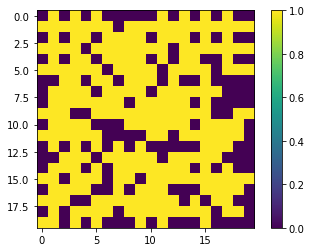

In [66]:



plt.imshow(base_grid)
plt.colorbar()
plt.show()


In [112]:
class GridWord(object):

    @classmethod
    def from_base_grid(cls, base_grid: np.ndarray, min_word_length = 2) -> list:

        grid_words = []
        # a word starts after each non-letter field, and at the beginning if there is
        # a letter field at the beginning of a row/column
        h, w = base_grid.shape

        # first get all horizontal words
        for y in range(h):
            word_start = 0
            for x in range(w):
                if not base_grid[y, x]:
                    if word_start < x:
                        word = GridWord(
                            y=y,
                            x=word_start,
                            is_vertical=False,
                            length=x - word_start
                        )
                        if word.length >= min_word_length:
                            grid_words.append(word)
                    
                    word_start = x + 1

            if word_start < w:
                word = GridWord(
                    y=y,
                    x=word_start,
                    is_vertical=False,
                    length=w - word_start
                )
                if word.length >= min_word_length:
                    grid_words.append(word)
        
        # then get all vertical word slots
        for x in range(w):
            word_start = 0
            for y in range(h):
                if not base_grid[y, x]:
                    if word_start < y:
                        word = GridWord(
                            y=word_start,
                            x=x,
                            is_vertical=True,
                            length=y - word_start
                        )

                        if word.length >= min_word_length:
                            grid_words.append(word)
                    
                    word_start = y + 1

            if word_start < h:
                word = GridWord(
                    y=word_start,
                    x=x,
                    is_vertical=True,
                    length=h - word_start
                )
                if word.length >= min_word_length:
                    grid_words.append(word)
        
        for i in range(len(grid_words)):
            grid_words[i].id = i
            for j in range(i):
                word_a = grid_words[i]
                word_b = grid_words[j]

                if word_a.check_connected(word_b):
                    word_a.connect_word(word_b)
                    word_b.connect_word(word_a)

        return grid_words

    def __init__(self, y: int, x: int, is_vertical: bool, length: int, id: int = None) -> None:
        self.x = x
        self.y = y
        self.is_vertical = is_vertical
        self.length = length
        self.word_key = None
        self.connected_words = []
        self.id = id

        self.candidate_cache = []
        self.candidate_cache_key = ""
    
    
    def get_letters(self, letter_grid: np.ndarray) -> list:
        if self.is_vertical:
            return letter_grid[self.y:self.y+self.length, self.x].flatten()
        return letter_grid[self.y, self.x: self.x + self.length].flatten()
    
    def set_letters(self, letters, letter_grid: np.ndarray):
        if self.is_vertical:
            letter_grid[self.y:self.y + self.length, self.x] = letters
        else:
            letter_grid[self.y, self.x: self.x + self.length] = letters
    
    def set_word_key(self, word_key:str):
        self.word_key = word_key
    
    def connect_word(self, grid_word):
        self.connected_words.append(grid_word)
    
    
    
    def check_connected(self, grid_word):
        if self.is_vertical == grid_word.is_vertical:
            return False
        
        if self.is_vertical:
            if self.y > grid_word.y:
                return False
            if self.y + self.length <= grid_word.y:
                return False
            
            if self.x >= grid_word.x + grid_word.length:
                return False
            
            if self.x < grid_word.x:
                return False
        
        else:
            if self.x > grid_word.x:
                return False
            if self.x + self.length <= grid_word.x:
                return False
            if self.y >= grid_word.y + grid_word.length:
                return False
            if self.y < grid_word.y:
                return False
        
        return True
    
    def get_candidates(self, letter_grid, db, inverted_db):
        letters = self.get_letters(letter_grid)
        word = "".join(letters) 
        if word == self.candidate_cache_key:
            return self.candidate_cache
        self.candidate_cache = find_suitable_words(letters, db, inverted_db)
        self.candidate_cache_key = word
        return self.candidate_cache
    
    def get_connected_words(self):
        return self.connected_words

    


class GridCreationState(object):
    def __init__(self, base_grid, db, inverted_db, letter_grid = None, grid_words = None, final_grid_words = None, used_ids = None) -> None:
        self.base_grid = base_grid
        self.shape = base_grid.shape
        self.db = db
        self.inverted_db = inverted_db
        

        if letter_grid is None:
            self.letter_grid = np.full(shape = self.shape, fill_value=' ', dtype=np.unicode)
        else:
            self.letter_grid = letter_grid
        
        if grid_words is None:
            self.grid_words = GridWord.from_base_grid(base_grid=base_grid)
        else:
            self.grid_words = grid_words

        
        if final_grid_words is None:
            self.final_grid_words = []
        else:
            self.final_grid_words = final_grid_words
        
        if used_ids is None:
            self.used_ids = [[False]] * len(self.grid_words)
        else:
            self.used_ids = used_ids
        


    def copy(self):
        return GridCreationState(self.base_grid, self.db, self.inverted_db, self.letter_grid.copy(), self.grid_words.copy(), self.final_grid_words.copy(), self.used_ids.copy())
    

    def set_random_word(self, last_word = None, n_retries = 1, max_preselected = 10):
        # choose random word

        preselected_id = None
        preselected_candidates = []

        for word in self.final_grid_words:
            connected_words = word.get_connected_words()
            #random.shuffle(connected_words)
            for connected_word in connected_words:
                if not self.used_ids[connected_word.id]:
                    preselected_id = connected_word.id
                    for i in range(preselected_id):
                        if self.used_ids[i]:
                            preselected_id -= 1
                    preselected_candidates.append(preselected_id)
                    
            
            if len(preselected_candidates) > 0:
                random.shuffle(preselected_candidates)
                break
            
        


        n_tries = 1
        if preselected_id is not None:
            n_tries = min(len(preselected_candidates), max_preselected)
        else:
            random_index = random.randint(0, len(self.grid_words) - 1)
        
        for i in range(n_tries):
            if preselected_id is not None:
                random_index = preselected_candidates[i]
            grid_word = self.grid_words[random_index]
            
            candidates_raw = list(grid_word.get_candidates(self.letter_grid, self.db, self.inverted_db))
            
    
            if len(candidates_raw) > 0:
                for j in range(min(n_retries, len(candidates_raw))):
                    word_key = candidates_raw[j]
                    word = normalize_word(self.db[word_key]['word'])

                    new_grid = self.letter_grid.copy()

                    grid_word.set_letters(list(word), new_grid)

                    for word in grid_word.get_connected_words():
                        if word.id not in self.used_ids:
                            n_cands = len(word.get_candidates(new_grid, self.db, self.inverted_db))
                            if n_cands == 0:
                                return None


                    self.letter_grid = new_grid
                    grid_word.set_word_key(word_key)
                    self.used_ids[grid_word.id] = True
                    self.final_grid_words.append(grid_word)
                    del(self.grid_words[random_index])

                    return grid_word
            
        return None
    
    
    def fill(self, depth = 0, last_word = None):
        if depth % 5 == 0:
            print("depth", depth)

        n_retries = 100 if depth == 0 else 2
        if len(self.grid_words) == 0:
            return self


        
        state_copy = self.copy()
        grid_word = None
        for _ in range(n_retries):
            
            
            grid_word = state_copy.set_random_word(last_word = last_word, n_retries=20, max_preselected = 2)
            if grid_word is not None:
            
                final_state = state_copy.fill(
                    depth = depth + 1,
                    last_word = grid_word)
                if final_state is not None:
                    return final_state
        return None

        
    



        


In [114]:
%%prun
base_grid = create_base_grid(14, min_word_length=3, max_word_length=12)

db = get_database("de")
inverted_db = get_inverted_database("de")

grid_state = GridCreationState(base_grid, db, inverted_db)

final_state = grid_state.fill()

print(final_state is not None)

depth 0
True
 

         1490 function calls (1488 primitive calls) in 0.004 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.003    0.003 <ipython-input-64-c07db7426ad7>:1(create_base_grid)
       14    0.000    0.000    0.000    0.000 {method 'astype' of 'numpy.ndarray' objects}
       14    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 <ipython-input-112-58b0ffc6eba3>:3(from_base_grid)
      184    0.000    0.000    0.000    0.000 random.py:238(_randbelow_with_getrandbits)
      184    0.000    0.000    0.000    0.000 random.py:291(randrange)
        2    0.000    0.000    0.000    0.000 <ipython-input-112-58b0ffc6eba3>:188(set_random_word)
        2    0.000    0.000    0.000    0.000 <ipython-input-2-026304d5612b>:92(find_suitable_words)
        1    0.000    0.000    0.004    0.004 {built-in method builtins.exec}
        7    0

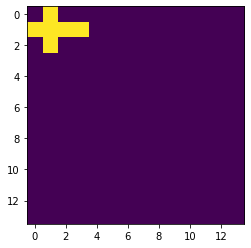

[[' ' 'm' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['a' 'a' 'c' 'h' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' 'i' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
mai ['aach0']
aach0 ['mai']


In [115]:

plt.imshow(base_grid)
plt.show()
print(final_state.letter_grid)
for grid_word in final_state.final_grid_words:
    connected = []
    for word in grid_word.connected_words:
        connected.append(word.word_key)
    print(grid_word.word_key, connected)

In [ ]:
grid_word

In [292]:
def create_word_grid(w: int, h: int, lang_code: str = "en", target_density: float = 0.5, difficulty: int = 0):
    np.full()



In [85]:
w = 5
h = 5

hh_index = np.zeros(shape=(h,w), dtype = int)
vv_index = np.zeros(shape=(w,h), dtype = int)


h_index = w - np.arange(w)
v_index = h - np.arange(h)

hh_index[:] = h_index
vv_index[:] = v_index
vv_index = vv_index.transpose()


horizontal_starting_points = np.full(shape=(h, w), dtype=int, fill_value=-1)
horizontal_starting_points[::2,::2] = 0
horizontal_starting_points[horizontal_starting_points == 0] = hh_index[horizontal_starting_points == 0]

vertical_starting_points = np.full(shape=(h, w), dtype=int, fill_value=-1)
vertical_starting_points[::2,::2] = 0
vertical_starting_points[vertical_starting_points == 0] = vv_index[vertical_starting_points == 0]

vertical_starting_points

array([[ 5, -1,  5, -1,  5],
       [-1, -1, -1, -1, -1],
       [ 3, -1,  3, -1,  3],
       [-1, -1, -1, -1, -1],
       [ 1, -1,  1, -1,  1]])

In [82]:
w = 10
h = 5

hh_index = np.zeros(shape=(h,w), dtype = int)
vv_index = np.zeros(shape=(w,h), dtype = int)


h_index = w - 1 - np.arange(w)
v_index = h - 1 - np.arange(h)

hh_index[:] = h_index
vv_index[:] = v_index
vv_index = vv_index.transpose()

hh_index


array([[9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
       [9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
       [9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
       [9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
       [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]])

In [87]:
l = [[1,2],[2,3]]

[1,3] in l

False

In [53]:
import pprint

grid, hints, solution = create_word_grid(10,20)

pprint.pprint(grid)

100
200
300
400
500
600
700
800
900
1000
1100
1200


RecursionError: maximum recursion depth exceeded while calling a Python object